# C8Steerable CNN


In [1]:
try:
    done
except:
    import os

    os.chdir("../../../")
    from utils.download import download
    from utils.extract import extract

    args = {"model": "Model-2"}
    download(args)
    extract("data/Model_II.tgz", "data/")
    extract("data/Model_II_test.tgz", "data/")
    done = True

Downloading...
From (uriginal): https://drive.google.com/uc?id=1HYPkdtVUj9xsoGzFDxT4rhl37KmqDCg4
From (redirected): https://drive.google.com/uc?id=1HYPkdtVUj9xsoGzFDxT4rhl37KmqDCg4&confirm=t&uuid=54657181-41fb-4159-a6f7-8616bd782eff
To: /opt/repo/GSoC-23/data/Model_II.tgz
100%|██████████| 2.84G/2.84G [00:23<00:00, 122MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1PFdpqk7XOAKtg0Cnav4HTzyJiudx9dZv
From (redirected): https://drive.google.com/uc?id=1PFdpqk7XOAKtg0Cnav4HTzyJiudx9dZv&confirm=t&uuid=86ef4005-7fcc-4510-937e-a5a958394621
To: /opt/repo/GSoC-23/data/Model_II_test.tgz
100%|██████████| 478M/478M [00:05<00:00, 84.0MB/s]


In [2]:
import copy
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from itertools import cycle
from PIL import Image
from sklearn.metrics import (
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
)
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


from tqdm import tqdm

warnings.filterwarnings("ignore")

# Data Preparation


In [3]:
train_transforms = transforms.Compose([
#     transforms.RandomCrop(128),
    transforms.Resize(128),
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=(0.8, 1.2)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [4]:
class AxionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_name = "axion"
        self.class_folder = os.path.join(self.root_dir, self.class_name)
        self.file_list = [f for f in os.listdir(self.class_folder) if f.endswith('.npy')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_name = self.file_list[idx]
        file_path = os.path.join(self.class_folder, file_name)
        data = np.load(file_path, allow_pickle=True)
        image = data[0]
        weight = data[1]
        image = 255 * (image / image.max())
        image = Image.fromarray(image.astype('uint8')).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image.float(), weight.astype('float32')
    

trainset = AxionDataset(
    root_dir='data/Model_II',
    transform = train_transforms
)

testset = AxionDataset(
    root_dir='data/Model_II_test',
    transform = test_transforms
)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)

In [5]:
lr = 0.0001
epochs = 30
gamma = 0.7
batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model


In [6]:
class args: ...
args.batch_size = 64
args.std_mult = 0.7
args.filter_gain = 2
args.filter_size = 5
args.n_rings = 4
args.n_filters = 8 
args.dim = 128
args.n_classes = 1

In [7]:
from models import HN

model = HN(args).to(device)

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=gamma)

# Training


In [8]:
all_train_loss = []
all_test_loss = []


best_loss = np.inf

for epoch in range(epochs):
    epoch_loss = 0
    model.train()
    tr_loss_epoch = []
    test_loss_epoch = []
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label).float()
        tr_loss_epoch.append(loss.item())
       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        epoch_loss += loss / len(train_loader)
    scheduler.step()
    all_train_loss.append(np.asarray(tr_loss_epoch))


    torch.cuda.empty_cache()
    with torch.no_grad():
        epoch_val_loss = 0
        for data, label in tqdm(test_loader):
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)
            test_loss_epoch.append(val_loss.item())

            epoch_val_loss += val_loss.item() / len(test_loader)
        all_test_loss.append(np.asarray(test_loss_epoch))

    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        best_model = copy.deepcopy(model)

    print(
        f"Epoch : {epoch+1} - train loss : {epoch_loss:.4f} - val_loss : {epoch_val_loss:.4f}%"
    )
torch.save(best_model.state_dict(), "equi_nn.pth")
all_train_loss_mean = [j.mean() for j in all_train_loss]
all_test_loss_mean = [j.mean() for j in all_test_loss]

100%|██████████| 79/79 [00:12<00:00,  6.52it/s]


Epoch : 1 - train loss : 68.3370 - val_loss : 11.4752%


100%|██████████| 79/79 [00:10<00:00,  7.34it/s]


Epoch : 2 - train loss : 7.5785 - val_loss : 5.6044%


100%|██████████| 79/79 [00:10<00:00,  7.39it/s]


Epoch : 3 - train loss : 4.1740 - val_loss : 3.4245%


100%|██████████| 79/79 [00:10<00:00,  7.37it/s]


Epoch : 4 - train loss : 2.6797 - val_loss : 2.3637%


100%|██████████| 79/79 [00:10<00:00,  7.36it/s]


Epoch : 5 - train loss : 1.8478 - val_loss : 1.6837%


100%|██████████| 79/79 [00:10<00:00,  7.32it/s]


Epoch : 6 - train loss : 1.3761 - val_loss : 1.3053%


100%|██████████| 79/79 [00:10<00:00,  7.36it/s]


Epoch : 7 - train loss : 1.0896 - val_loss : 1.0278%


100%|██████████| 79/79 [00:10<00:00,  7.35it/s]


Epoch : 8 - train loss : 0.8588 - val_loss : 0.8463%


100%|██████████| 79/79 [00:10<00:00,  7.32it/s]


Epoch : 9 - train loss : 0.6722 - val_loss : 0.6426%


100%|██████████| 79/79 [00:10<00:00,  7.27it/s]


Epoch : 10 - train loss : 0.5177 - val_loss : 0.4945%


100%|██████████| 79/79 [00:10<00:00,  7.20it/s]


Epoch : 11 - train loss : 0.4073 - val_loss : 0.3980%


100%|██████████| 79/79 [00:10<00:00,  7.38it/s]


Epoch : 12 - train loss : 0.3319 - val_loss : 0.3209%


100%|██████████| 79/79 [00:10<00:00,  7.34it/s]


Epoch : 13 - train loss : 0.2669 - val_loss : 0.2664%


100%|██████████| 79/79 [00:10<00:00,  7.35it/s]


Epoch : 14 - train loss : 0.2098 - val_loss : 0.2036%


100%|██████████| 79/79 [00:10<00:00,  7.38it/s]


Epoch : 15 - train loss : 0.1607 - val_loss : 0.1533%


100%|██████████| 79/79 [00:10<00:00,  7.27it/s]


Epoch : 16 - train loss : 0.1232 - val_loss : 0.1192%


100%|██████████| 79/79 [00:10<00:00,  7.35it/s]


Epoch : 17 - train loss : 0.0981 - val_loss : 0.0959%


100%|██████████| 79/79 [00:11<00:00,  7.13it/s]


Epoch : 18 - train loss : 0.0761 - val_loss : 0.0746%


100%|██████████| 79/79 [00:10<00:00,  7.25it/s]


Epoch : 19 - train loss : 0.0575 - val_loss : 0.0559%


100%|██████████| 79/79 [00:10<00:00,  7.27it/s]


Epoch : 20 - train loss : 0.0421 - val_loss : 0.0538%


100%|██████████| 79/79 [00:10<00:00,  7.21it/s]


Epoch : 21 - train loss : 0.0310 - val_loss : 0.0294%


100%|██████████| 79/79 [00:11<00:00,  7.12it/s]


Epoch : 22 - train loss : 0.0234 - val_loss : 0.0249%


100%|██████████| 79/79 [00:10<00:00,  7.21it/s]


Epoch : 23 - train loss : 0.0175 - val_loss : 0.0173%


100%|██████████| 79/79 [00:10<00:00,  7.24it/s]


Epoch : 24 - train loss : 0.0124 - val_loss : 0.0149%


100%|██████████| 79/79 [00:10<00:00,  7.24it/s]


Epoch : 25 - train loss : 0.0086 - val_loss : 0.0099%


100%|██████████| 79/79 [00:10<00:00,  7.22it/s]


Epoch : 26 - train loss : 0.0057 - val_loss : 0.0065%


100%|██████████| 79/79 [00:10<00:00,  7.24it/s]


Epoch : 27 - train loss : 0.0043 - val_loss : 0.0043%


100%|██████████| 79/79 [00:10<00:00,  7.20it/s]


Epoch : 28 - train loss : 0.0030 - val_loss : 0.0031%


100%|██████████| 79/79 [00:10<00:00,  7.22it/s]


Epoch : 29 - train loss : 0.0022 - val_loss : 0.0029%


100%|██████████| 79/79 [00:10<00:00,  7.25it/s]

Epoch : 30 - train loss : 0.0015 - val_loss : 0.0014%


# Plotting Loss and Accuracy


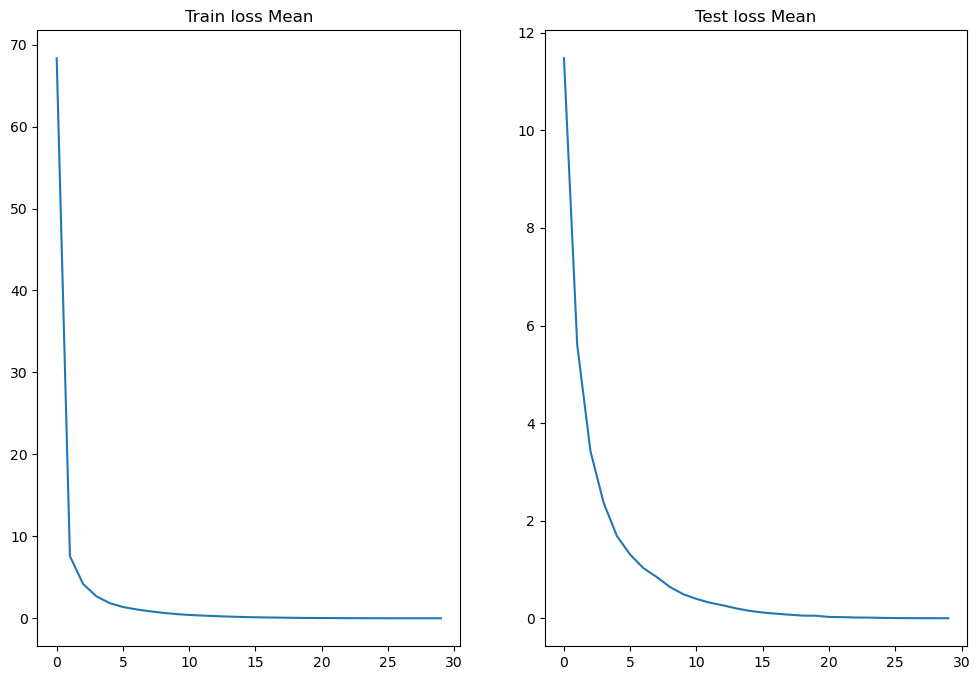

In [9]:
figure = plt.figure(figsize=(12, 8))
cols, rows = 2, 1
figure.add_subplot(rows, cols, 1)
plt.title("Train loss Mean")
plt.plot(all_train_loss_mean)
figure.add_subplot(rows, cols, 2)
plt.title("Test loss Mean")
plt.plot(all_test_loss_mean)

# Loading Best Model


In [10]:
model = HN(args).to(device)
model.load_state_dict(torch.load("equi_nn.pth"), strict=False)

<All keys matched successfully>

# Testing


In [11]:
import torch.nn.functional as F
with torch.no_grad():
    model.eval()
    rmse_list = []
    mse_list = []
    mae_list = []
    
    for i, (x, y) in enumerate(tqdm(test_loader)):
        x = x.to(device)
        y = y.to(device)
        _y = model(x)
        
        # Calculate metrics
        rmse = torch.sqrt(F.mse_loss(_y, y))
        mse = F.mse_loss(_y, y)
        mae = F.l1_loss(_y, y)
        
        rmse_list.append(rmse.item())
        mse_list.append(mse.item())
        mae_list.append(mae.item())

# Calculate overall metrics
avg_rmse = np.mean(rmse_list)
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)

print("Average RMSE:", avg_rmse)
print("Average MSE:", avg_mse)
print("Average MAE:", avg_mae)

100%|██████████| 79/79 [00:10<00:00,  7.29it/s]

Average RMSE: 0.02792396207776251
Average MSE: 0.0007877417186516797
Average MAE: 0.021819029581037503
